<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/assign_2/assign_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Flowers using Transfer Learning in Keras

Assignment 2 - Convolutional Neural Nets and Transfer Learning

By Gordon Chan (qq525548)


In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(42)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_dir = "/content/gdrive/MyDrive/3546/assign_2/flower_photos"

In [4]:
os.listdir(data_dir)

['tulips', 'roses', 'sunflowers', 'dandelion', 'daisy']

## Loading data

In [46]:
from sklearn.model_selection import train_test_split

# Get the list of classes (folders)
classes = ['tulips', 'roses', 'sunflowers', 'dandelion', 'daisy']

# Initialize the lists to store the images and labels
images = []
labels = []

# Loop through each class folder
for class_ in classes:
    # Get the list of images in the current class folder
    image_paths = tf.io.gfile.glob(f'{data_dir}/{class_}/*.jpg')

    # Loop through each image
    for image_path in image_paths:
        # Read the image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)

        # Add the image and label to the lists
        images.append(image)
        labels.append(class_)

# Split the data into training and testing sets (80% for training and 20% for testing)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Print the shapes of the training and testing sets
print(f'Training images shape: {len(train_images)}')
print(f'Testing images shape: {len(test_images)}')

Training images shape: 2936
Testing images shape: 734


In [55]:
def show_images(images, num, labels):
    plt.figure(figsize=(10, 10))
    for i in range(num):
      plt.subplot(3, 3, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      plt.xlabel(labels[i])
    plt.show()

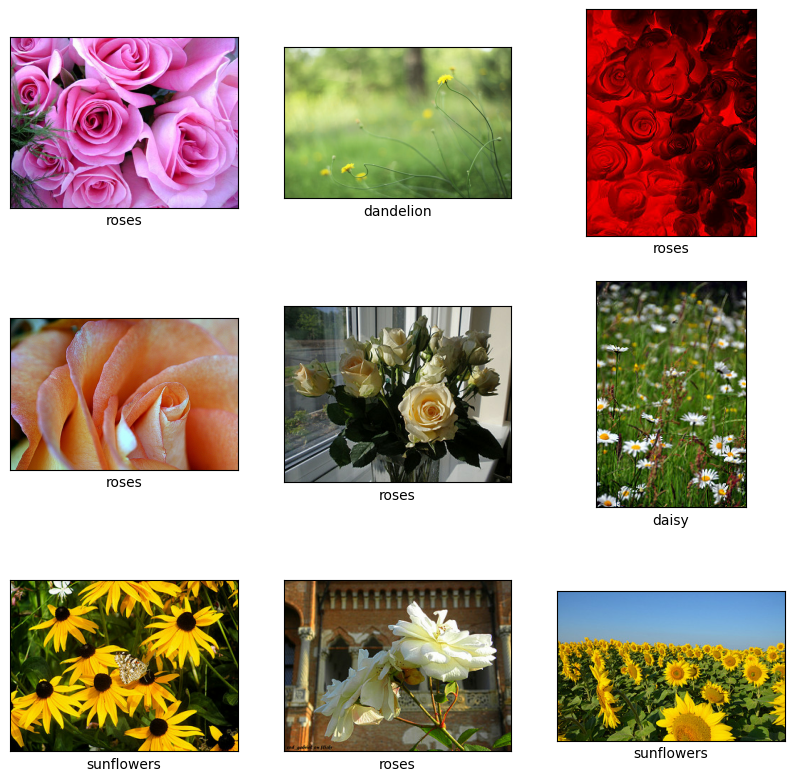

In [56]:
show_images(train_images, 9, train_labels)

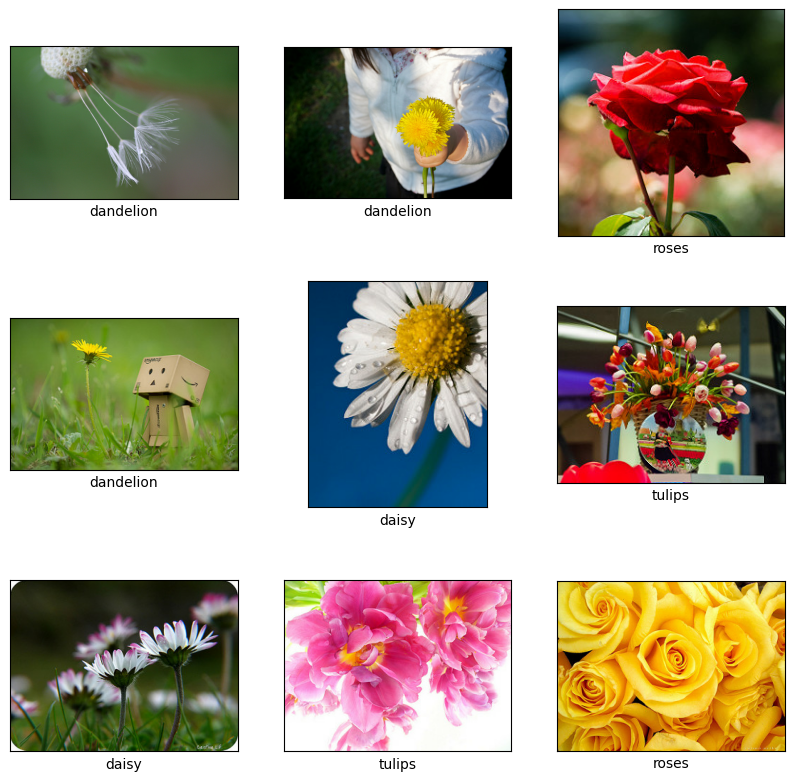

In [57]:
show_images(test_images, 9, test_labels)